In [1]:
import numpy as np  # this module handles arrays, but here we need it for its NaN value
import pandas as pd # this module contains a lot of tools for handling tabular data
from matplotlib import pyplot as plt
from salishsea_tools import evaltools as et
import datetime as dt
import os
import gsw
import pickle
import netCDF4 as nc
import cmocean
from scipy import stats as spst
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [2]:
# Base Parameters
modSourceDir = "/results2/SalishSea/nowcast-green.201905/"
modver = "201905"
Chl_N = 1.8
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2018,12,31)
clusterD='/data/tjarniko/MEOPAR/analysis_tereza/notebooks/CLUSTER_PAPER/CLEAN/KEY_PAPERFIGURES/pkls/'
cxf='Xcoords_for571_stations.pkl'
cyf='Ycoords_for571_stations.pkl'
cfile={2015:'BIO_clno_5_2015_reass.pkl',
       2016:'BIO_clno_5_2016_reass.pkl'} # only 2015 and 2016 overlap with hplc
cver='BIOMASS'

In [3]:
# Parameters
modSourceDir = "/results2/SalishSea/nowcast-green.201905/"
modver = "201905"
Chl_N = 1.8
cfile = {
    "2015": "BIOMASS_clno_5_2015_reass.pkl",
    "2016": "BIOMASS_clno_5_2016_reass.pkl",
}
cver = "BIOMASS"


In [4]:
# papermill reads dictionary keys as strings, so add code to correct this
cfile2=dict()
for key,val in cfile.items():
    cfile2[int(key)]=val
cfile=cfile2

In [5]:
print('Cluster version is:', cver)

Cluster version is: BIOMASS


In [6]:
def logt(x):
    return np.log10(x+.001)

## First, assign each row of HPLC data frame a cluster ID

In [7]:
cx=pickle.load(open(clusterD+cxf, 'rb'))
cy=pickle.load(open(clusterD+cyf, 'rb'))

In [8]:
cf=dict()
for iyear in cfile.keys():
    cf[iyear]=pickle.load(open(clusterD+cfile[iyear],'rb'))

In [9]:
cx[:5],cy[:5]

(array([12, 12, 12, 12, 12]), array([382, 392, 402, 412, 422]))

In [10]:
# 7-16=>12; 17-26=>22, etc
def round2(num):
    return int(np.trunc((num+2)/10)*10+2)

In [11]:
datestr='_'+start_date.strftime('%Y%m%d')+'_'+end_date.strftime('%Y%m%d')
data=pickle.load(open( 'matched_'+modver+datestr+'.pkl', 'rb' ) )

data['other']=0.0
for el in ('Cryptophytes', 'Cyanobacteria', 'Dictyochophytes', 'Dinoflagellates',
    'Haptophytes', 'Prasinophytes', 'Raphidophytes'):
    data['other']=data['other']+data[el]
    
def yd(idt):
    if type(idt)==dt.datetime:
        yd=(idt-dt.datetime(idt.year-1,12,31)).days
    else: # assume array or pandas
        yd=[(ii-dt.datetime(ii.year-1,12,31)).days for ii in idt]
    return yd

data['yd']=yd(data['dtUTC'])
data['Year']=[ii.year for ii in data['dtUTC']]

data['mod_diatoms_chl']=Chl_N*data['mod_diatoms']
data['mod_flagellates_chl']=Chl_N*data['mod_flagellates']
data['mod_ciliates_chl']=Chl_N*data['mod_ciliates']
data['mod_TChl']=data['mod_diatoms_chl']+data['mod_flagellates_chl']+data['mod_ciliates_chl']
data['CCPH']=data['Cyanobacteria']+data['Cryptophytes']+data['Prasinophytes']+data['Haptophytes']
data['DD']=data['Diatoms-1']+data['Diatoms-2']
data2=data.loc[(data.Year<2017)&(data.i>7)]
data=data2.copy(deep=True).reset_index()

In [12]:
data['Cluster']=np.zeros(len(data))

In [13]:
for ir, row in data.iterrows():
    ii=(cx==round2(row['i']))&(cy==round2(row['j']))
    if sum(ii)==1:
        cluster=cf[row['Year']][ii]
        data.at[ir,'Cluster']=int(cluster)

In [14]:
np.sum(data['Cluster']==0),len(data)

(62, 2238)

### map HPLC data by cluster; 0 was not close to a cluster point

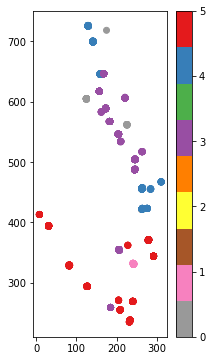

In [15]:
fig,ax=plt.subplots(1,1,figsize=(3,6))
cm0='Set1_r'
m=ax.scatter(data['i'],data['j'],c=data['Cluster'],cmap=cm0)
fig.colorbar(m)

In [16]:
data.keys()

Index(['index', 'FIL:START TIME YYYY/MM/DD HH:MM:SS', 'LOC:STATION', 'Lat',
       'Lon', 'LOC:WATER DEPTH', 'Sample_Number', 'Temperature', 'Salinity',
       'Oxygen:Dissolved:CTD', 'pH:SBE:Nominal', 'Salinity:Bottle',
       'Flag:Salinity:Bottle', 'Flag:Chlorophyll:Extracted',
       'Flag:Nitrate_plus_Nitrite', 'Flag:Silicate', 'Flag:Phosphate',
       'Cruise', 'Oxygen:Dissolved', 'Flag:Oxygen:Dissolved', 'Cyanobacteria',
       'Prasinophytes', 'Cryptophytes', 'Diatoms-1', 'Diatoms-2',
       'Haptophytes', 'TchlA (ug/L)', 'Pressure [decibar]',
       'Transmissivity [*/metre]', 'PAR [uE/m^2/sec]',
       'PAR:Reference [uE/m^2/sec]', 'Oxygen:Dissolved:SBE [mL/L]',
       'Oxygen:Dissolved:SBE [umol/kg]', 'Chlorophyll:Extracted [mg/m^3]',
       'Phaeo-Pigment:Extracted [mg/m^3]', 'Nitrate_plus_Nitrite [umol/L]',
       'Silicate [umol/L]', 'Phosphate [umol/L]', 'Bottle_Number',
       'Oxygen:Dissolved [mL/L]', 'Oxygen:Dissolved [umol/kg]',
       'Depth [metres]', 'Fluorescenc

Text(0, 0.5, 'Numer of HPLC Samples')

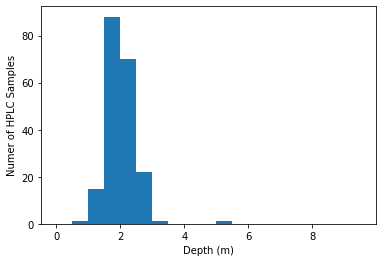

In [17]:
## Depths!
plt.hist(data.loc[data.DD>=0,['Z']].values,np.arange(0,10,.5));
plt.xlabel('Depth (m)')
plt.ylabel('Numer of HPLC Samples')

In [18]:
np.arange(0,10,.5)

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
       6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5])

In [19]:
print('number of data points in each cluster:')
data.loc[:,['Cluster','Diatoms-1']].groupby('Cluster').count()

number of data points in each cluster:


,Diatoms-1
Cluster,
0.0,10
1.0,7
3.0,85
4.0,47
5.0,50


In [20]:
data.loc[:,['Pressure [decibar]','Diatoms-1']]

,Pressure [decibar],Diatoms-1
0,1.5,24.471
1,6.5,NaN
2,11.6,NaN
3,21.8,NaN
4,31.6,NaN
...,...,...
2233,175.1,NaN
2234,200.0,NaN
2235,249.9,NaN
2236,299.8,NaN


### plot Diatoms versus HPLC Diatoms 1 and 2 and flagellates versus HPLC CCPH=cyano+crypto+prasino+hapto for each cluster

By Cluster:


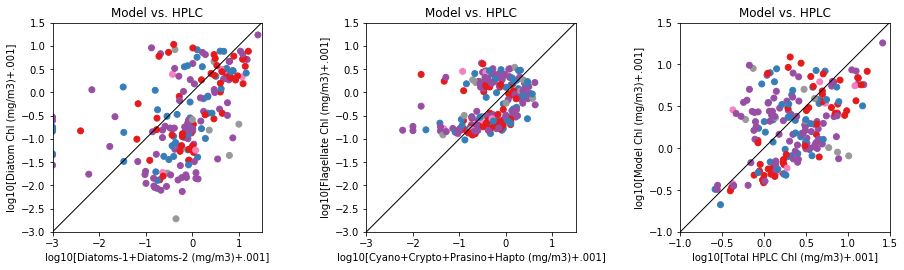

In [21]:
fig,ax=plt.subplots(1,3,figsize=(15,5))
fig.subplots_adjust(wspace=.5)
m=ax[0].scatter(logt(data['DD']),logt(data['mod_diatoms_chl']),c=data['Cluster'],cmap=cm0)
ax[0].set_aspect(1)
ax[0].set_xlim(-3,1.5)
ax[0].set_ylim(-3,1.5)
ax[0].plot((-3,1.5),(-3,1.5),'k-',lw=1)
ax[0].set_xlabel('log10[Diatoms-1+Diatoms-2 (mg/m3)+.001]')
ax[0].set_ylabel('log10[Diatom Chl (mg/m3)+.001]')
ax[0].set_title('Model vs. HPLC')
ax[1].scatter(logt(data['CCPH']),logt(data['mod_flagellates_chl']),c=data['Cluster'],cmap=cm0)
ax[1].set_aspect(1)
ax[1].set_xlim(-3,1.5)
ax[1].set_ylim(-3,1.5)
ax[1].plot((-3,1.5),(-3,1.5),'k-',lw=1)
ax[1].set_xlabel('log10[Cyano+Crypto+Prasino+Hapto (mg/m3)+.001]')
ax[1].set_ylabel('log10[Flagellate Chl (mg/m3)+.001]')
ax[1].set_title('Model vs. HPLC')

ax[2].scatter(logt(data['TchlA (ug/L)']),logt(data['mod_TChl']),c=data['Cluster'],cmap=cm0)
ax[2].set_aspect(1)
ax[2].set_xlim(-1,1.5)
ax[2].set_ylim(-1,1.5)
ax[2].plot((-3,1.5),(-3,1.5),'k-',lw=1)
ax[2].set_xlabel('log10[Total HPLC Chl (mg/m3)+.001]')
ax[2].set_ylabel('log10[Model Chl (mg/m3)+.001]')
ax[2].set_title('Model vs. HPLC')
#fig.colorbar(m)
print('By Cluster:')

Same plots, by Season:


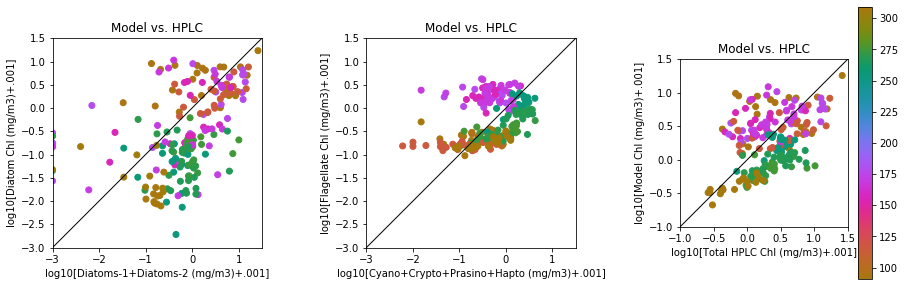

In [22]:
print('Same plots, by Season:')
fig,ax=plt.subplots(1,3,figsize=(15,5))
fig.subplots_adjust(wspace=.5)
m=ax[0].scatter(logt(data['DD']),logt(data['mod_diatoms_chl']),c=data['yd'],cmap=cmocean.cm.phase)
ax[0].set_aspect(1)
ax[0].set_xlim(-3,1.5)
ax[0].set_ylim(-3,1.5)
ax[0].plot((-3,1.5),(-3,1.5),'k-',lw=1)
ax[0].set_xlabel('log10[Diatoms-1+Diatoms-2 (mg/m3)+.001]')
ax[0].set_ylabel('log10[Diatom Chl (mg/m3)+.001]')
ax[0].set_title('Model vs. HPLC')
ax[1].scatter(logt(data['CCPH']),logt(data['mod_flagellates_chl']),c=data['yd'],cmap=cmocean.cm.phase)
ax[1].set_aspect(1)
ax[1].set_xlim(-3,1.5)
ax[1].set_ylim(-3,1.5)
ax[1].plot((-3,1.5),(-3,1.5),'k-',lw=1)
ax[1].set_xlabel('log10[Cyano+Crypto+Prasino+Hapto (mg/m3)+.001]')
ax[1].set_ylabel('log10[Flagellate Chl (mg/m3)+.001]')
ax[1].set_title('Model vs. HPLC')

m=ax[2].scatter(logt(data['TchlA (ug/L)']),logt(data['mod_TChl']),c=data['yd'],cmap=cmocean.cm.phase)
ax[2].set_aspect(1)
ax[2].set_xlim(-1,1.5)
ax[2].set_ylim(-1,1.5)
ax[2].plot((-3,1.5),(-3,1.5),'k-',lw=1)
ax[2].set_xlabel('log10[Total HPLC Chl (mg/m3)+.001]')
ax[2].set_ylabel('log10[Model Chl (mg/m3)+.001]')
ax[2].set_title('Model vs. HPLC')
fig.colorbar(m,ax=ax[2])
#fig.colorbar(m)

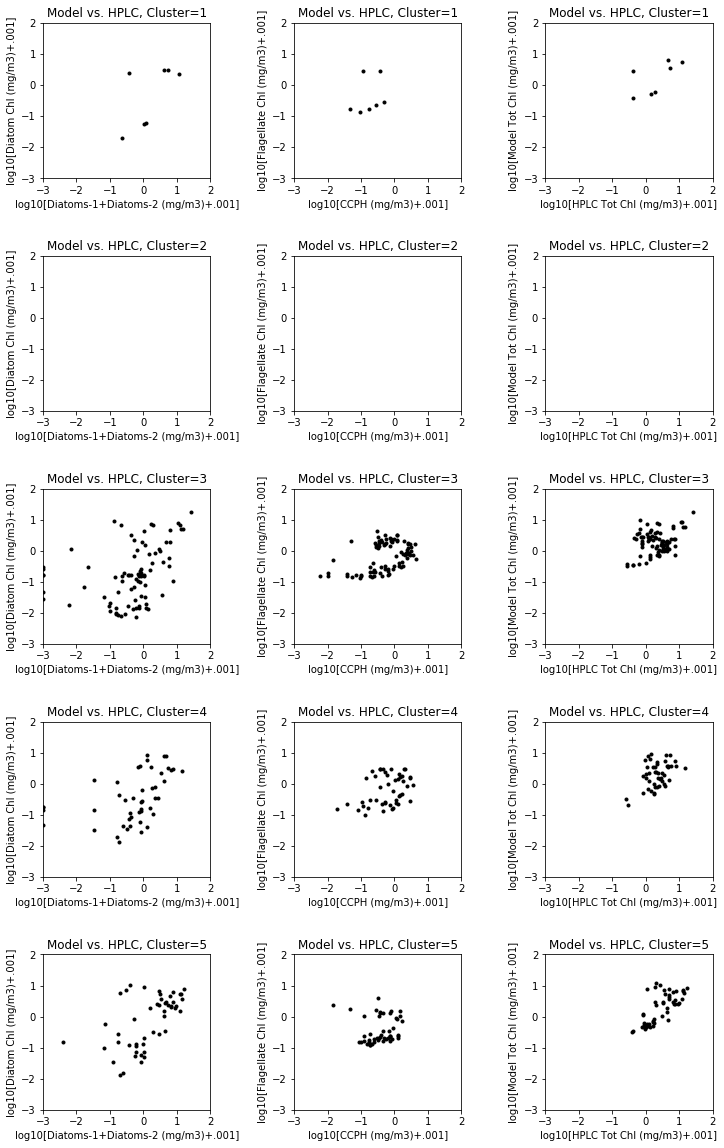

In [23]:
fig,ax=plt.subplots(5,3,figsize=(12,20))
fig.subplots_adjust(hspace=.5,wspace=.5)
for el in range(1,6):
    idata=data.loc[data.Cluster==el]
    ax[el-1,0].plot(logt(idata['DD']),logt(idata['mod_diatoms_chl']),'k.')
    ax[el-1,0].set_xlabel('log10[Diatoms-1+Diatoms-2 (mg/m3)+.001]')
    ax[el-1,0].set_ylabel('log10[Diatom Chl (mg/m3)+.001]')
    ax[el-1,0].set_title('Model vs. HPLC, Cluster='+str(el))
    
    ax[el-1,1].plot(logt(idata['CCPH']),logt(idata['mod_flagellates_chl']),'k.')
    ax[el-1,1].set_xlabel('log10[CCPH (mg/m3)+.001]')
    ax[el-1,1].set_ylabel('log10[Flagellate Chl (mg/m3)+.001]')
    ax[el-1,1].set_title('Model vs. HPLC, Cluster='+str(el))
    
    ax[el-1,2].plot(logt(idata['TchlA (ug/L)']),logt(idata['mod_TChl']),'k.')
    ax[el-1,2].set_xlabel('log10[HPLC Tot Chl (mg/m3)+.001]')
    ax[el-1,2].set_ylabel('log10[Model Tot Chl (mg/m3)+.001]')
    ax[el-1,2].set_title('Model vs. HPLC, Cluster='+str(el))
for iax in ax.flatten():
    iax.set_xlim(-3,2)
    iax.set_ylim(-3,2)

### as chl fraction

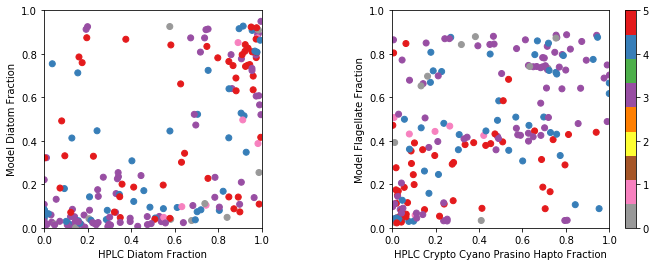

In [24]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
diatFracMod=data['mod_diatoms']/(data['mod_diatoms']+data['mod_flagellates']+data['mod_ciliates'])
diatFracObs=data['DD']/data['TchlA (ug/L)']
m=ax[0].scatter(diatFracObs,diatFracMod,
          c=data['Cluster'],cmap=cm0)
ax[0].set_xlabel('HPLC Diatom Fraction')
ax[0].set_ylabel('Model Diatom Fraction')
ax[0].set_xlim((0,1))
ax[0].set_ylim((0,1))
flFracMod=data['mod_flagellates']/(data['mod_diatoms']+data['mod_flagellates']+data['mod_ciliates'])
CCPHFracObs=data['CCPH']/data['TchlA (ug/L)']
m=ax[1].scatter(CCPHFracObs,flFracMod,
          c=data['Cluster'],cmap=cm0)
ax[1].set_xlabel('HPLC Crypto Cyano Prasino Hapto Fraction')
ax[1].set_ylabel('Model Flagellate Fraction')
ax[1].set_xlim((0,1))
ax[1].set_ylim((0,1))
ax[0].set_aspect(1)
ax[1].set_aspect(1)

fig.colorbar(m)

### Species makeup by cluster

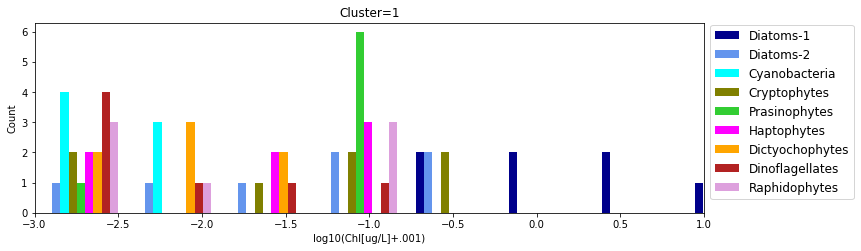

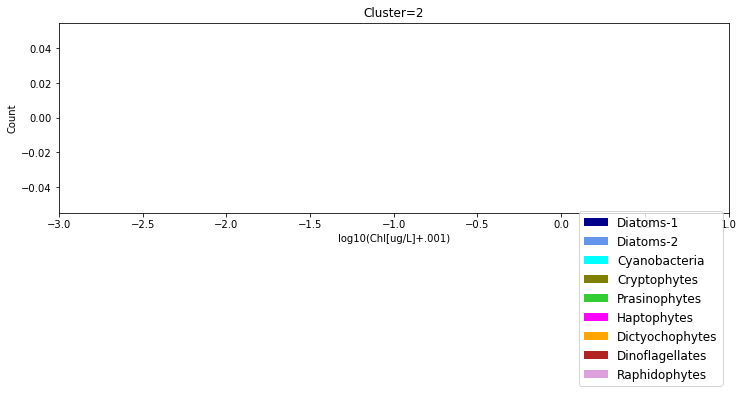

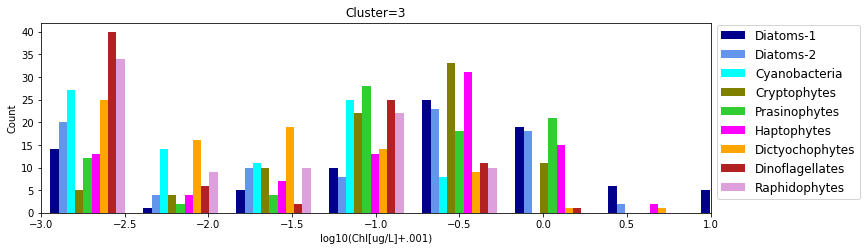

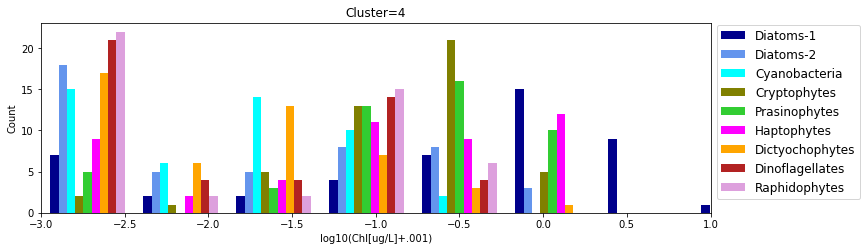

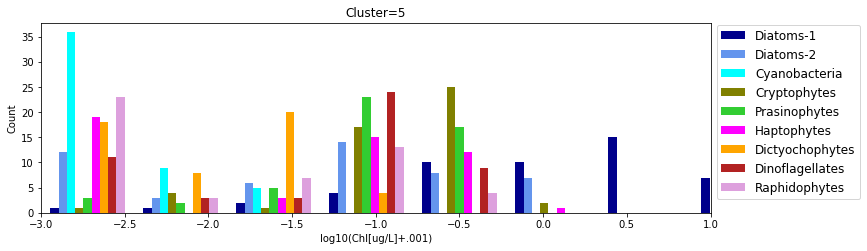

In [25]:
for icluster in range(1,6):
    fig,ax=plt.subplots(1,1,figsize=(12,3.5))
    idata=data.loc[data.Cluster==icluster]
    hplclist=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
           'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes')
    x=np.array([logt(idata[el]) for el in hplclist]).T
    cols=('darkblue','cornflowerblue','cyan','olive','limegreen','magenta','orange','firebrick','plum')
    bins=np.linspace(-3,2,10)
    ax.hist(x, bins, density=False, histtype='bar', color=cols, label=hplclist);
    ax.legend(prop={'size': 12},bbox_to_anchor=(1,0.04));
    ax.set_xlim(-3,1)
    ax.set_xlabel('log10(Chl[ug/L]+.001)')
    ax.set_ylabel('Count')
    ax.set_title('Cluster='+str(icluster))

### Seasonality by Cluster (color=cluster; see map at top of page)

In [26]:
## Mean and stdev for yd 150-280:
for icluster in (3,4,):
    print('Cluster: ',icluster)
    print('  Year days 150-280: ')
    print('    Diatoms-1+2 Mean: ',np.nanmean(data.loc[(data.yd>=150)&(data.yd<=280)&(data.Cluster==icluster),['DD']]))
    print('    Diatoms-1+2 St. Dev.: ',np.nanstd(data.loc[(data.yd>=150)&(data.yd<=280)&(data.Cluster==icluster),['DD']]))
    print('    Model Diatoms Mean: ',np.nanmean(data.loc[(data.yd>=150)&(data.yd<=280)&(data.Cluster==icluster),['mod_diatoms_chl']]))
    print('    Model Diatoms St. Dev.: ',np.nanstd(data.loc[(data.yd>=150)&(data.yd<=280)&(data.Cluster==icluster),['mod_diatoms_chl']]))

Cluster:  3
  Year days 150-280: 
    Diatoms-1+2 Mean:  1.2671379310344828
    Diatoms-1+2 St. Dev.:  2.1718219226570237
    Model Diatoms Mean:  0.1933702168071178
    Model Diatoms St. Dev.:  0.7019099221079897
Cluster:  4
  Year days 150-280: 
    Diatoms-1+2 Mean:  1.20515625
    Diatoms-1+2 St. Dev.:  1.3909333671445003
    Model Diatoms Mean:  0.20301461154481443
    Model Diatoms St. Dev.:  0.5355424420073948


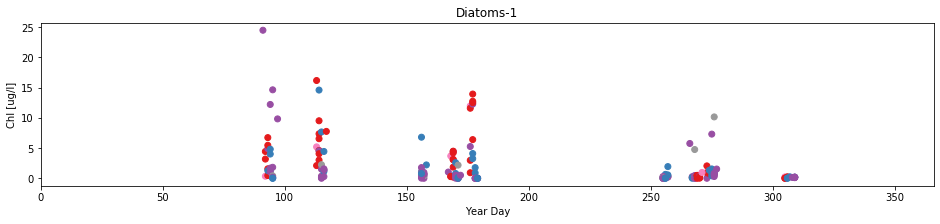

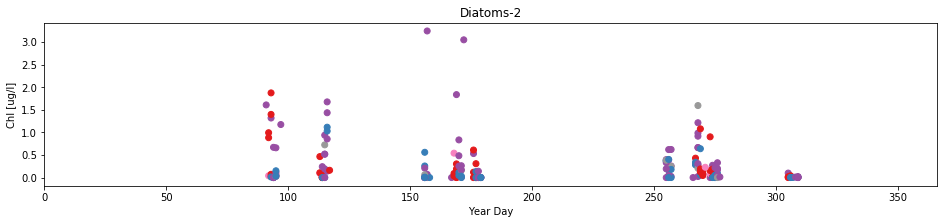

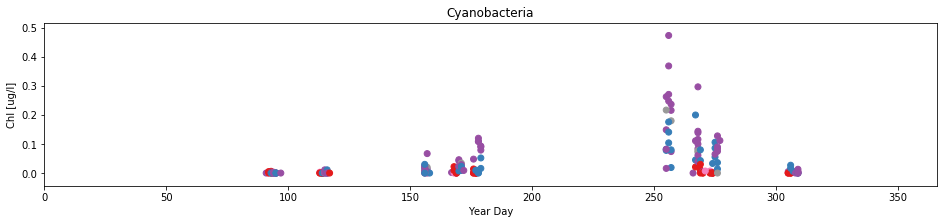

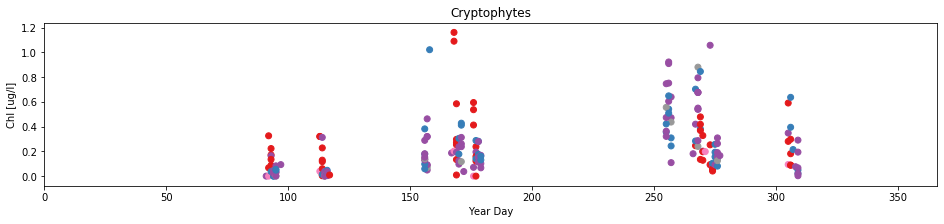

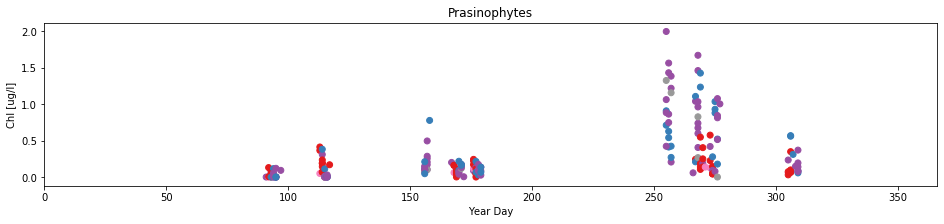

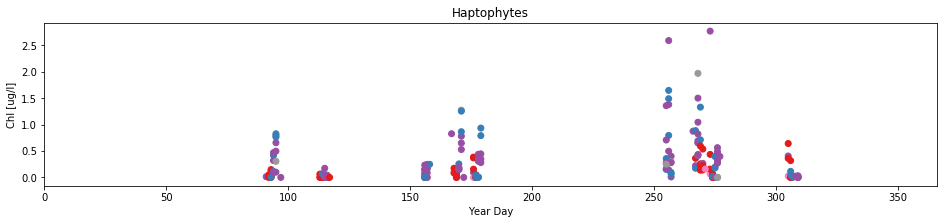

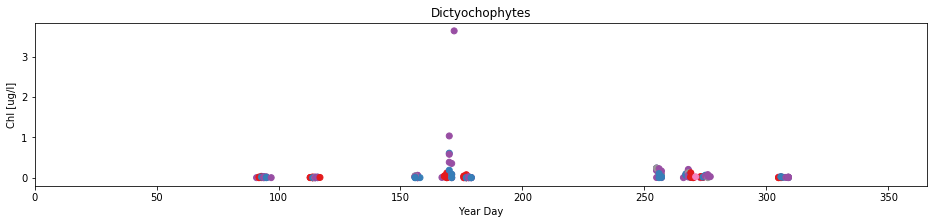

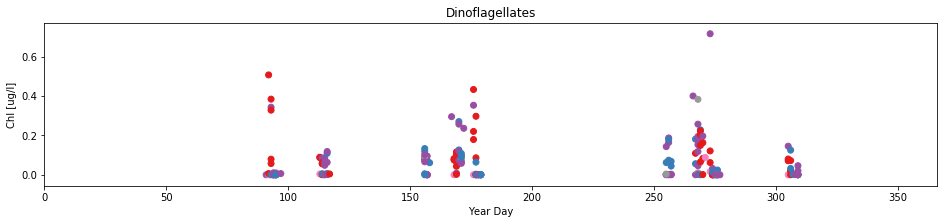

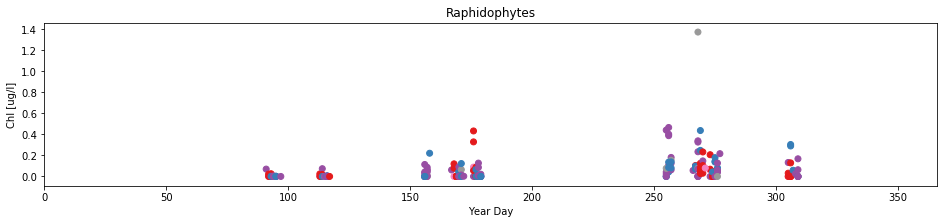

In [27]:
for i in range(0,len(hplclist)):
    fig,ax=plt.subplots(1,1,figsize=(16,3))
    ax.scatter(data['yd'],data[hplclist[i]],c=data['Cluster'],label=hplclist[i],cmap=cm0)
    #ax.set_ylim(-3,1)
    ax.set_xlim((0,366))
    ax.set_title((hplclist[i]))
    ax.set_xlabel('Year Day')
    ax.set_ylabel('Chl [ug/l]')

Residuals: Model - Obs


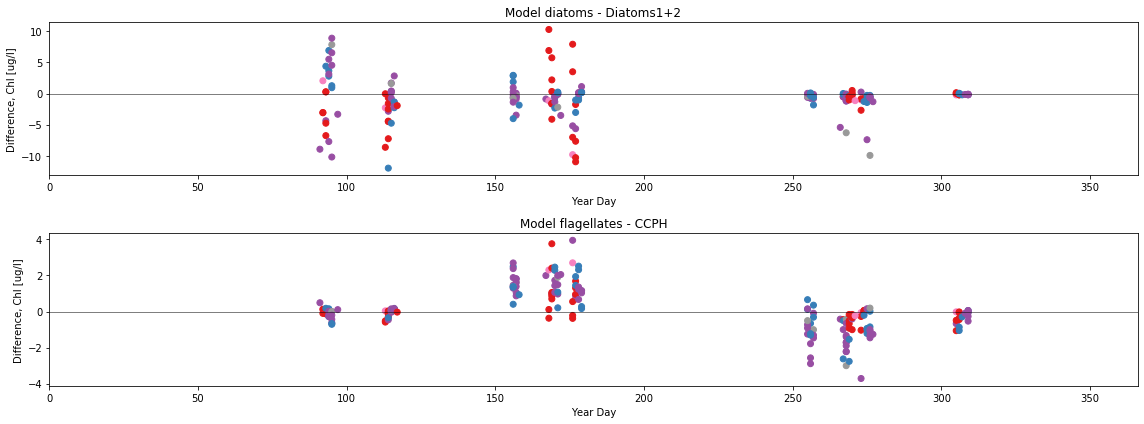

In [28]:
print('Residuals: Model - Obs')
fig,ax=plt.subplots(2,1,figsize=(16,6))
ax[0].scatter(data['yd'],data['mod_diatoms_chl']-data['DD'],c=data['Cluster'],label=hplclist[i],cmap=cm0)
ax[0].set_xlim((0,366))
ax[0].set_title('Model diatoms - Diatoms1+2')
ax[0].set_xlabel('Year Day')
ax[0].set_ylabel('Difference, Chl [ug/l]')
ax[0].plot((0,366),(0,0),'k-',lw=.5)

ax[1].scatter(data['yd'],data['mod_flagellates_chl']-data['CCPH'],c=data['Cluster'],label=hplclist[i],cmap=cm0)
ax[1].set_xlim((0,366))
ax[1].set_title('Model flagellates - CCPH')
ax[1].set_xlabel('Year Day')
ax[1].set_ylabel('Difference, Chl [ug/l]')
ax[1].plot((0,366),(0,0),'k-',lw=.5)
plt.tight_layout()

### Covariance Matrices

In [29]:
icluster=1
print('Cluster',icluster)
idata=data.loc[data.Cluster==icluster,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
   'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
               'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]
idata.cov()

Cluster 1


,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,17.982473,-0.085762,-0.001709,-0.138147,0.048377,-0.116030,-0.014663,-0.039840,0.073285,17.896711,-0.207509,17.708618,2.932403,3.885786,0.539620,7.357808
Diatoms-2,-0.085762,0.036747,-0.000036,0.012955,0.000391,0.007329,0.002271,0.001081,-0.001560,-0.049015,0.020639,-0.026649,0.087746,0.104741,0.005999,0.198486
Cyanobacteria,-0.001709,-0.000036,0.000010,0.000073,0.000121,0.000079,0.000002,0.000074,0.000089,-0.001745,0.000283,-0.001298,-0.002535,-0.001329,-0.000120,-0.003984
Cryptophytes,-0.138147,0.012955,0.000073,0.007169,0.001601,0.004210,0.001037,0.001568,0.000099,-0.125192,0.013054,-0.109433,-0.033948,0.010174,-0.001866,-0.025641
Prasinophytes,0.048377,0.000391,0.000121,0.001601,0.002421,0.001093,0.000135,0.000971,0.001763,0.048769,0.005236,0.056884,-0.041055,0.010529,0.001065,-0.029461
Haptophytes,-0.116030,0.007329,0.000079,0.004210,0.001093,0.003378,0.000569,0.001470,0.000553,-0.108701,0.008760,-0.097340,-0.027344,-0.002444,-0.001832,-0.031620
Dictyochophytes,-0.014663,0.002271,0.000002,0.001037,0.000135,0.000569,0.000165,0.000141,-0.000064,-0.012393,0.001742,-0.010409,-0.000573,0.004870,0.000053,0.004350
Dinoflagellates,-0.039840,0.001081,0.000074,0.001568,0.000971,0.001470,0.000141,0.001058,0.000736,-0.038759,0.004083,-0.032727,-0.024777,-0.011909,-0.001370,-0.038056
Raphidophytes,0.073285,-0.001560,0.000089,0.000099,0.001763,0.000553,-0.000064,0.000736,0.001696,0.071725,0.002504,0.076615,-0.024743,0.012039,0.001875,-0.010829
DD,17.896711,-0.049015,-0.001745,-0.125192,0.048769,-0.108701,-0.012393,-0.038759,0.071725,17.847697,-0.186870,17.681969,3.020148,3.990527,0.545619,7.556294


In [30]:
icluster=2
print('Cluster',icluster)
idata=data.loc[data.Cluster==icluster,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
   'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
               'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]
idata.cov()

Cluster 2


/home/eolson/anaconda3/envs/py38_ct_pmill/lib/python3.8/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/eolson/anaconda3/envs/py38_ct_pmill/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/eolson/anaconda3/envs/py38_ct_pmill/lib/python3.8/site-packages/pandas/core/frame.py:7654: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
/home/eolson/anaconda3/envs/py38_ct_pmill/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/eolson/anaconda3/envs/py38_ct_pmill/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Diatoms-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cyanobacteria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cryptophytes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Prasinophytes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Haptophytes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dictyochophytes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dinoflagellates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Raphidophytes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
icluster=3
print('Cluster',icluster)
idata=data.loc[data.Cluster==icluster,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
   'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
               'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]
idata.cov()

Cluster 3


,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,14.284976,0.579242,-0.074232,-0.232040,-0.388172,-0.388947,-0.126322,-0.017428,-0.057576,14.864217,-1.083391,13.579367,7.488014,-0.524577,0.092140,7.055577
Diatoms-2,0.579242,0.375309,-0.003375,-0.009752,0.005012,-0.071815,0.123791,0.001382,-0.011377,0.954551,-0.079931,0.988428,0.300073,-0.036610,-0.007602,0.255862
Cyanobacteria,-0.074232,-0.003375,0.008368,0.015762,0.030394,0.015274,0.000405,-0.000983,0.004551,-0.077607,0.069797,-0.003832,-0.068307,0.009625,-0.003049,-0.061732
Cryptophytes,-0.232040,-0.009752,0.015762,0.062048,0.086298,0.076287,-0.001051,0.009378,0.013335,-0.241792,0.240395,0.020263,-0.220185,0.030240,-0.011722,-0.201666
Prasinophytes,-0.388172,0.005012,0.030394,0.086298,0.221851,0.057708,-0.000660,-0.005265,0.020572,-0.383160,0.396251,0.027753,-0.382615,0.007713,-0.026364,-0.401267
Haptophytes,-0.388947,-0.071815,0.015274,0.076287,0.057708,0.243215,-0.010577,0.031494,0.024453,-0.460762,0.392485,-0.022946,-0.176127,0.027351,-0.013121,-0.161897
Dictyochophytes,-0.126322,0.123791,0.000405,-0.001051,-0.000660,-0.010577,0.170770,0.009281,-0.001822,-0.002532,-0.011883,0.163781,-0.123210,0.073576,-0.009058,-0.058692
Dinoflagellates,-0.017428,0.001382,-0.000983,0.009378,-0.005265,0.031494,0.009281,0.013637,0.001266,-0.016047,0.034625,0.042749,-0.056963,0.017740,-0.000285,-0.039508
Raphidophytes,-0.057576,-0.011377,0.004551,0.013335,0.020572,0.024453,-0.001822,0.001266,0.011396,-0.068953,0.062910,0.004807,-0.058948,0.003775,-0.002975,-0.058147
DD,14.864217,0.954551,-0.077607,-0.241792,-0.383160,-0.460762,-0.002532,-0.016047,-0.068953,15.818769,-1.163322,14.567795,7.788087,-0.561186,0.084538,7.311438


In [32]:
icluster=4
print('Cluster',icluster)
idata=data.loc[data.Cluster==icluster,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
   'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
               'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]
idata.cov()

Cluster 4


,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,6.955311,-0.041326,-0.041130,-0.166111,-0.175366,-0.376660,-0.024958,-0.034991,-0.063718,6.913985,-0.759268,6.030669,2.264917,-0.227385,0.134826,2.172358
Diatoms-2,-0.041326,0.064045,0.002328,0.004860,0.007486,0.007102,0.003471,0.006583,-0.002325,0.022720,0.021777,0.052230,-0.011078,-0.029440,0.003142,-0.037376
Cyanobacteria,-0.041130,0.002328,0.002273,0.005989,0.011500,0.012266,0.000888,0.001206,0.001278,-0.038802,0.032028,-0.003396,-0.037655,-0.000986,-0.002584,-0.041226
Cryptophytes,-0.166111,0.004860,0.005989,0.055611,0.057656,0.050507,0.004755,0.008748,0.013409,-0.161251,0.169762,0.035450,-0.228629,0.086600,-0.009823,-0.151852
Prasinophytes,-0.175366,0.007486,0.011500,0.057656,0.139787,0.059471,0.007012,0.006506,0.026511,-0.167880,0.268413,0.140603,-0.341225,-0.014965,-0.025271,-0.381461
Haptophytes,-0.376660,0.007102,0.012266,0.050507,0.059471,0.197357,0.002701,0.011369,0.009533,-0.369558,0.319601,-0.026264,-0.259252,0.063177,-0.015487,-0.211562
Dictyochophytes,-0.024958,0.003471,0.000888,0.004755,0.007012,0.002701,0.010115,0.003973,-0.000134,-0.021486,0.015356,0.007819,-0.041998,0.036449,-0.003630,-0.009180
Dinoflagellates,-0.034991,0.006583,0.001206,0.008748,0.006506,0.011369,0.003973,0.004556,0.001254,-0.028407,0.027829,0.009201,-0.035132,0.022115,0.000269,-0.012748
Raphidophytes,-0.063718,-0.002325,0.001278,0.013409,0.026511,0.009533,-0.000134,0.001254,0.009688,-0.066043,0.050732,-0.004495,-0.079813,-0.008937,-0.006263,-0.095013
DD,6.913985,0.022720,-0.038802,-0.161251,-0.167880,-0.369558,-0.021486,-0.028407,-0.066043,6.936704,-0.737491,6.082899,2.253840,-0.256826,0.137968,2.134982


In [33]:
icluster=5
print('Cluster',icluster)
idata=data.loc[data.Cluster==icluster,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
   'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
               'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]
idata.cov()

Cluster 5


,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,17.410608,0.169322,-0.008340,-0.217612,-0.019759,-0.289626,-0.025955,0.055346,-0.092833,17.579930,-0.535337,16.981058,4.329100,0.659069,0.257870,5.246039
Diatoms-2,0.169322,0.158515,0.000527,0.001759,0.008576,0.004778,0.000810,0.025930,-0.001554,0.327838,0.015641,0.368594,-0.085184,-0.038459,0.001516,-0.122127
Cyanobacteria,-0.008340,0.000527,0.000045,0.000913,0.000298,0.000432,0.000111,0.000182,0.000178,-0.007813,0.001689,-0.005655,0.002921,0.000706,0.000045,0.003671
Cryptophytes,-0.217612,0.001759,0.000913,0.058576,0.008700,0.016422,0.001435,0.009015,0.009459,-0.215852,0.084611,-0.111358,0.378324,0.034776,0.007412,0.420513
Prasinophytes,-0.019759,0.008576,0.000298,0.008700,0.017865,0.010248,0.000884,0.002808,0.005281,-0.011183,0.037112,0.034904,0.017538,-0.018124,0.001092,0.000506
Haptophytes,-0.289626,0.004778,0.000432,0.016422,0.010248,0.028951,0.001500,0.004309,0.007632,-0.284849,0.056053,-0.215361,-0.065674,-0.012335,-0.004420,-0.082429
Dictyochophytes,-0.025955,0.000810,0.000111,0.001435,0.000884,0.001500,0.000711,0.000311,0.000531,-0.025145,0.003929,-0.019667,0.000880,0.008640,0.000267,0.009787
Dinoflagellates,0.055346,0.025930,0.000182,0.009015,0.002808,0.004309,0.000311,0.013671,0.004116,0.081276,0.016313,0.115670,0.061303,0.003084,0.003396,0.067783
Raphidophytes,-0.092833,-0.001554,0.000178,0.009459,0.005281,0.007632,0.000531,0.004116,0.007710,-0.094387,0.022550,-0.059473,0.066117,0.000605,0.001349,0.068071
DD,17.579930,0.327838,-0.007813,-0.215852,-0.011183,-0.284849,-0.025145,0.081276,-0.094387,17.907768,-0.519696,17.349652,4.243916,0.620611,0.259386,5.123912


### Correlation matrices

In [34]:
icluster=1
print('Cluster',icluster)
idata=data.loc[data.Cluster==icluster,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
   'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
               'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]
idata.corr()

Cluster 1


,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.000000,-0.105501,-0.128087,-0.384745,0.231871,-0.470756,-0.269230,-0.288794,0.419654,0.998981,-0.295988,0.996408,0.481240,0.734380,0.909275,0.712966
Diatoms-2,-0.105501,1.000000,-0.059396,0.798136,0.041510,0.657758,0.922213,0.173292,-0.197633,-0.060523,0.651243,-0.033170,0.318550,0.437899,0.223603,0.425464
Cyanobacteria,-0.128087,-0.059396,1.000000,0.273762,0.782517,0.432655,0.037699,0.727435,0.687435,-0.131265,0.544229,-0.098402,-0.560466,-0.338490,-0.272749,-0.520161
Cryptophytes,-0.384745,0.798136,0.273762,1.000000,0.384389,0.855388,0.953205,0.569213,0.028358,-0.349979,0.932492,-0.308378,-0.279022,0.096293,-0.157463,-0.124432
Prasinophytes,0.231871,0.041510,0.782517,0.384389,1.000000,0.382096,0.214170,0.606875,0.870212,0.234629,0.643695,0.275866,-0.580713,0.171504,0.154658,-0.246054
Haptophytes,-0.470756,0.657758,0.432655,0.855388,0.382096,1.000000,0.761622,0.777240,0.230974,-0.442685,0.911610,-0.399593,-0.327395,-0.033694,-0.225277,-0.223540
Dictyochophytes,-0.269230,0.922213,0.037699,0.953205,0.214170,0.761622,1.000000,0.337586,-0.121049,-0.228399,0.820409,-0.193387,-0.031024,0.303904,0.029280,0.139183
Dinoflagellates,-0.288794,0.173292,0.727435,0.569213,0.606875,0.777240,0.337586,1.000000,0.549526,-0.282019,0.759233,-0.240038,-0.530046,-0.293379,-0.300862,-0.480687
Raphidophytes,0.419654,-0.197633,0.687435,0.028358,0.870212,0.230974,-0.121049,0.549526,1.000000,0.412268,0.367786,0.443908,-0.418130,0.234293,0.325341,-0.108049
DD,0.998981,-0.060523,-0.131265,-0.349979,0.234629,-0.442685,-0.228399,-0.282019,0.412268,1.000000,-0.267553,0.998658,0.497508,0.757017,0.922847,0.734959


In [35]:
icluster=2
print('Cluster',icluster)
idata=data.loc[data.Cluster==icluster,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
   'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
               'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]
idata.corr()

Cluster 2


,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Diatoms-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cyanobacteria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cryptophytes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Prasinophytes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Haptophytes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dictyochophytes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dinoflagellates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Raphidophytes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
icluster=3
print('Cluster',icluster)
idata=data.loc[data.Cluster==icluster,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
   'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
               'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]
idata.corr()

Cluster 3


,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.000000,0.250164,-0.214710,-0.246467,-0.218049,-0.208668,-0.080879,-0.039487,-0.142699,0.988817,-0.273439,0.933912,0.733773,-0.147090,0.129060,0.699476
Diatoms-2,0.250164,1.000000,-0.060223,-0.063907,0.017369,-0.237699,0.488976,0.019316,-0.173961,0.391758,-0.124461,0.419389,0.181413,-0.063331,-0.065692,0.156491
Cyanobacteria,-0.214710,-0.060223,1.000000,0.691763,0.705425,0.338569,0.010709,-0.091995,0.465993,-0.213311,0.727869,-0.010889,-0.276567,0.111507,-0.176487,-0.252866
Cryptophytes,-0.246467,-0.063907,0.691763,1.000000,0.735539,0.621003,-0.010210,0.322405,0.501470,-0.244057,0.920615,0.021145,-0.327385,0.128659,-0.249128,-0.303354
Prasinophytes,-0.218049,0.017369,0.705425,0.735539,1.000000,0.248434,-0.003389,-0.095722,0.409128,-0.204533,0.802518,0.015316,-0.300861,0.017354,-0.296327,-0.319214
Haptophytes,-0.208668,-0.237699,0.338569,0.621003,0.248434,1.000000,-0.051899,0.546854,0.464467,-0.234907,0.759176,-0.012094,-0.132271,0.058775,-0.140848,-0.123005
Dictyochophytes,-0.080879,0.488976,0.010709,-0.010210,-0.003389,-0.051899,1.000000,0.192325,-0.041313,-0.001540,-0.027430,0.103021,-0.110427,0.188689,-0.116042,-0.053217
Dinoflagellates,-0.039487,0.019316,-0.091995,0.322405,-0.095722,0.546854,0.192325,1.000000,0.101584,-0.034549,0.282839,0.095156,-0.180662,0.160989,-0.012898,-0.126766
Raphidophytes,-0.142699,-0.173961,0.465993,0.501470,0.409128,0.464467,-0.041313,0.101584,1.000000,-0.162400,0.562153,0.011705,-0.204513,0.037474,-0.147514,-0.204094
DD,0.988817,0.391758,-0.213311,-0.244057,-0.204533,-0.234907,-0.001540,-0.034549,-0.162400,1.000000,-0.279016,0.952081,0.725236,-0.149532,0.112525,0.688806


In [37]:
icluster=4
print('Cluster',icluster)
idata=data.loc[data.Cluster==icluster,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
   'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
               'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]
idata.corr()

Cluster 4


,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.000000,-0.061918,-0.327092,-0.267093,-0.177850,-0.321488,-0.094093,-0.196571,-0.245462,0.995391,-0.323949,0.915291,0.397567,-0.086615,0.220379,0.352942
Diatoms-2,-0.061918,1.000000,0.192970,0.081433,0.079121,0.063172,0.136381,0.385414,-0.093335,0.034086,0.096826,0.082609,-0.020264,-0.116866,0.053515,-0.063282
Cyanobacteria,-0.327092,0.192970,1.000000,0.532638,0.645099,0.579112,0.185256,0.374749,0.272426,-0.308989,0.755867,-0.028507,-0.365604,-0.020784,-0.233646,-0.370484
Cryptophytes,-0.267093,0.081433,0.532638,1.000000,0.653927,0.482108,0.200487,0.549583,0.577718,-0.259626,0.810030,0.060171,-0.448818,0.368915,-0.179556,-0.275913
Prasinophytes,-0.177850,0.079121,0.645099,0.653927,1.000000,0.358049,0.186474,0.257812,0.720394,-0.170486,0.807812,0.150526,-0.422497,-0.040211,-0.291369,-0.437166
Haptophytes,-0.321488,0.063172,0.579112,0.482108,0.358049,1.000000,0.060441,0.379163,0.218023,-0.315849,0.809510,-0.023663,-0.270154,0.142863,-0.150281,-0.204052
Dictyochophytes,-0.094093,0.136381,0.185256,0.200487,0.186474,0.060441,1.000000,0.585207,-0.013573,-0.081115,0.171802,0.031119,-0.193313,0.364072,-0.155598,-0.039108
Dinoflagellates,-0.196571,0.385414,0.374749,0.549583,0.257812,0.379163,0.585207,1.000000,0.188823,-0.159801,0.463935,0.054565,-0.240960,0.329153,0.017167,-0.080930
Raphidophytes,-0.245462,-0.093335,0.272426,0.577718,0.720394,0.218023,-0.013573,0.188823,1.000000,-0.254760,0.579969,-0.018277,-0.375380,-0.091212,-0.274305,-0.413613
DD,0.995391,0.034086,-0.308989,-0.259626,-0.170486,-0.315849,-0.081115,-0.159801,-0.254760,1.000000,-0.315080,0.924455,0.396153,-0.097960,0.225816,0.347334


In [38]:
icluster=5
print('Cluster',icluster)
idata=data.loc[data.Cluster==icluster,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
   'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
               'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]
idata.corr()

Cluster 5


,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.000000,0.101923,-0.296797,-0.215484,-0.035429,-0.407939,-0.233345,0.113443,-0.253383,0.995610,-0.302853,0.984477,0.384219,0.210036,0.632310,0.409450
Diatoms-2,0.101923,1.000000,0.196696,0.018259,0.161162,0.070523,0.076275,0.557024,-0.044455,0.194582,0.092733,0.223955,-0.079234,-0.128448,0.038959,-0.099897
Cyanobacteria,-0.296797,0.196696,1.000000,0.559975,0.331548,0.376995,0.617098,0.231106,0.300722,-0.274142,0.591844,-0.203137,0.160613,0.139354,0.067837,0.177532
Cryptophytes,-0.215484,0.018259,0.559975,1.000000,0.268951,0.398769,0.222434,0.318580,0.445124,-0.210753,0.825234,-0.111304,0.578884,0.191070,0.313344,0.565842
Prasinophytes,-0.035429,0.161162,0.331548,0.268951,1.000000,0.450601,0.248000,0.179648,0.449947,-0.019771,0.655420,0.063172,0.048593,-0.180311,0.083574,0.001233
Haptophytes,-0.407939,0.070523,0.376995,0.398769,0.450601,1.000000,0.330691,0.216577,0.510863,-0.395602,0.777632,-0.306182,-0.142938,-0.096398,-0.265788,-0.157770
Dictyochophytes,-0.233345,0.076275,0.617098,0.222434,0.248000,0.330691,1.000000,0.099666,0.227055,-0.222907,0.347958,-0.178472,0.012228,0.431003,0.102399,0.119570
Dinoflagellates,0.113443,0.557024,0.231106,0.318580,0.179648,0.216577,0.099666,1.000000,0.400949,0.164264,0.329351,0.239315,0.194165,0.035069,0.297177,0.188798
Raphidophytes,-0.253383,-0.044455,0.300722,0.445124,0.449947,0.510863,0.227055,0.400949,1.000000,-0.254023,0.606235,-0.163852,0.278857,0.009169,0.157220,0.252478
DD,0.995610,0.194582,-0.274142,-0.210753,-0.019771,-0.395602,-0.222907,0.164264,-0.254023,1.000000,-0.289894,0.991786,0.371393,0.195015,0.627136,0.394328


### Stats by cluster and group

In [39]:
data.keys()

Index(['index', 'FIL:START TIME YYYY/MM/DD HH:MM:SS', 'LOC:STATION', 'Lat',
       'Lon', 'LOC:WATER DEPTH', 'Sample_Number', 'Temperature', 'Salinity',
       'Oxygen:Dissolved:CTD', 'pH:SBE:Nominal', 'Salinity:Bottle',
       'Flag:Salinity:Bottle', 'Flag:Chlorophyll:Extracted',
       'Flag:Nitrate_plus_Nitrite', 'Flag:Silicate', 'Flag:Phosphate',
       'Cruise', 'Oxygen:Dissolved', 'Flag:Oxygen:Dissolved', 'Cyanobacteria',
       'Prasinophytes', 'Cryptophytes', 'Diatoms-1', 'Diatoms-2',
       'Haptophytes', 'TchlA (ug/L)', 'Pressure [decibar]',
       'Transmissivity [*/metre]', 'PAR [uE/m^2/sec]',
       'PAR:Reference [uE/m^2/sec]', 'Oxygen:Dissolved:SBE [mL/L]',
       'Oxygen:Dissolved:SBE [umol/kg]', 'Chlorophyll:Extracted [mg/m^3]',
       'Phaeo-Pigment:Extracted [mg/m^3]', 'Nitrate_plus_Nitrite [umol/L]',
       'Silicate [umol/L]', 'Phosphate [umol/L]', 'Bottle_Number',
       'Oxygen:Dissolved [mL/L]', 'Oxygen:Dissolved [umol/kg]',
       'Depth [metres]', 'Fluorescenc

In [40]:
def printStats0(s,descript):
    print('  '+descript)
    print('     N=         ',s[0])
    print('     model mean=',s[1])
    print('     obs mean=  ',s[2])
    print('     bias=      ',s[3])
    print('     RMSE=      ',s[4])
    print('     WSS=       ',s[5])

def printStatsAll(icluster,data):
    idata=data.loc[data.Cluster==icluster]
    sD=et.stats(idata['DD'],idata['mod_diatoms_chl'])
    sF=et.stats(idata['CCPH'],idata['mod_flagellates_chl'])
    sT=et.stats(idata['TchlA (ug/L)'],idata['mod_TChl'])
    dataHPLCLocs=idata.loc[idata.DD>=0]
    sTem=et.stats(dataHPLCLocs['CT'],dataHPLCLocs['mod_votemper'])
    sSal=et.stats(dataHPLCLocs['SA'],dataHPLCLocs['mod_vosaline'])## units?
    print('Cluster=',icluster)
    printStats0(sD,'Diatoms-1+Diatoms-2 and Model Diatoms')
    printStats0(sF,'Crypto+Cyano+Prasino+Hapto and Model Flagellates')
    printStats0(sT,'Total Chlorophyll (ug/L)')
    printStats0(sTem,'Conservative Temperature')
    printStats0(sSal,'Reference Salinity')

In [41]:
for icluster in range(1,6):
    printStatsAll(icluster,data)
    data['Temperature']

Cluster= 1
  Diatoms-1+Diatoms-2 and Model Diatoms
     N=          7
     model mean= 1.541199406449284
     obs mean=   3.4787142857142856
     bias=       -1.9375148792650017
     RMSE=       3.9553006767020715
     WSS=        0.52738272203478
  Crypto+Cyano+Prasino+Hapto and Model Flagellates
     N=          7
     model mean= 0.9191453722970826
     obs mean=   0.22599999999999998
     bias=       0.6931453722970826
     RMSE=       1.345124594944328
     WSS=        0.10880015854805625
  Total Chlorophyll (ug/L)
     N=          7
     model mean= 2.7860084700797287
     obs mean=   3.7647142857142852
     bias=       -0.9787058156345565
     RMSE=       2.8928754068985754
     WSS=        0.7546943933533866
  Conservative Temperature
     N=          7
     model mean= 11.740195683070592
     obs mean=   10.779180372580294
     bias=       0.9610153104902981
     RMSE=       1.356938458645703
     WSS=        0.754007701433208
  Reference Salinity
     N=          7
     model

/home/eolson/anaconda3/envs/py38_ct_pmill/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/eolson/anaconda3/envs/py38_ct_pmill/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1108: RuntimeWarning: invalid value encountered in double_scalars
  RMSE=np.sqrt(np.sum((mod-obs)**2)/N)
/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1109: RuntimeWarning: invalid value encountered in double_scalars
  WSS=1.0-np.sum((mod-obs)**2)/np.sum((np.abs(mod-obsmean)+np.abs(obs-obsmean))**2)
